# Imports

In [25]:
from utils_models import *
# import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
# import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

# Normalization Values

In [ ]:
# r_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_aerialr.tif')
# r_mean, r_std = get_norm_data(r_paths)

# g_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_aerialg.tif')
# g_mean, g_std = get_norm_data(g_paths)

# b_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_aerialb.tif')
# b_mean, b_std = get_norm_data(b_paths)

# rgb_means = [r_mean, g_mean, b_mean]
# rgb_stds = [r_std, g_std, b_std]

# print(rgb_means)
# print(rgb_stds)

In [ ]:
# dem_paths = glob.glob(r'../data/warren/patches_09_27_2024/*_dem*.tif')
# dem_means, dem_stds = get_norm_data(dem_paths)

# print(dem_means)
# print(dem_stds)

# Example Batch

RGB
type: <class 'torch.Tensor'>  |  dtype: torch.float32  |  shape: torch.Size([2, 3, 256, 256])  |  min: 3.1325292587280273  |  max: 254.0
DEM
type: <class 'torch.Tensor'>  |  dtype: torch.float32  |  shape: torch.Size([2, 1, 256, 256])  |  min: 597.962646484375  |  max: 622.4135131835938
Label
type: <class 'torch.Tensor'>  |  dtype: torch.float32  |  shape: torch.Size([2, 1, 7])




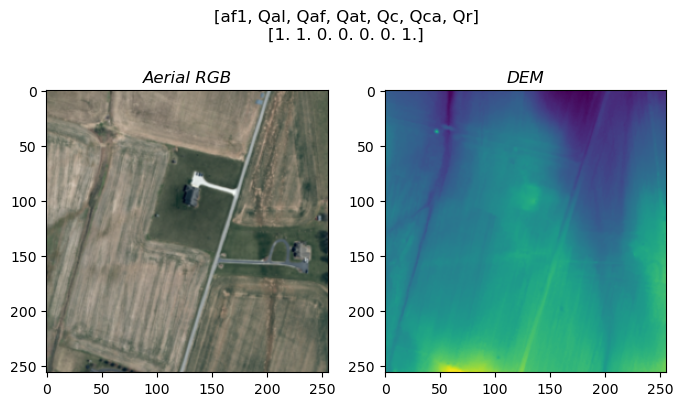

In [22]:
# get list of patch ids in dataset...
patch_ids_path = r'../data/warren/patches_09_27_2024/patch_ids.csv'    # path to patch id csv
patch_ids = pd.read_csv(patch_ids_path, header=None)                              # read csv as df
patch_ids = patch_ids.iloc[:,0].to_list()                                         # df to series to list

# call custom dataset (no transforms for plotting here)...
example_dataset = MultiModalDataset(patch_ids,
                                    r'../data/warren/patches_09_27_2024',
                                    transform_rgb=None,
                                    transform_dem=None,
                                    horiz_flip=True, 
                                    vert_flip=True, 
                                    rand_rot=True)

# create dataloader of batch size 1
example_loader = DataLoader(example_dataset, batch_size=2)

# get first batch from dataloader
batch = next(iter(example_loader))

# print type, dtype, shape, min value, and max values...
print(f"RGB\ntype: {type(batch['rgb'])}  |  dtype: {batch['rgb'].dtype}  |  shape: {batch['rgb'].shape}  |  min: {batch['rgb'].min()}  |  max: {batch['rgb'].max()}")
print(f"DEM\ntype: {type(batch['dem'])}  |  dtype: {batch['dem'].dtype}  |  shape: {batch['dem'].shape}  |  min: {batch['dem'].min()}  |  max: {batch['dem'].max()}")
print(f"Label\ntype: {type(batch['label'])}  |  dtype: {batch['label'].dtype}  |  shape: {batch['label'].shape}")
print('\n')

# plot example batch...
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

# prepare images for plotting with imshow (copy, to numpy, minmaxscaler)
rgb_example = prep_image_for_plot(batch['rgb'][0])
dem_example = prep_image_for_plot(batch['dem'][0])
label_example = batch['label'][0].numpy()

# plot images with label as title
ax[0].imshow(rgb_example, vmin=0, vmax=255)
ax[0].set_title('Aerial RGB', style='italic')
ax[1].imshow(dem_example, cmap='viridis')
ax[1].set_title('DEM', style='italic')
plt.suptitle(f"[af1, Qal, Qaf, Qat, Qc, Qca, Qr]\n{label_example.squeeze()}", y=1.05)
plt.show()

# DataLoaders

In [23]:
# get list of patch ids in dataset
patch_ids_path = r'../data/warren/patches_09_27_2024/patch_ids.csv'    # path to patch id csv
patch_ids = pd.read_csv(patch_ids_path, header=None)                              # read csv as dataframe
patch_ids = patch_ids.iloc[:,0].to_list()                                         # df to series to list


# training, validation, and testing sets
train_size = int(len(patch_ids) * 0.7)
val_size = int(len(patch_ids) * 0.15)
test_size = len(patch_ids) - train_size - val_size


# randomly split list of patch ids into train, validation, and test sets
train_patches, val_patches, test_patches = random_split(patch_ids, [train_size, val_size, test_size])


# define transforms...
# normalization values calculated from entire dataset
rgb_means = [82.34144592285156, 82.34144592285156, 60.32989501953125]
rgb_stds = [35.15250749710626, 35.15250749710626, 11.364835230788147]
dem_means = [693.0260620117188]
dem_stds = [58.23499697372154]

rgb_transforms = transforms.Compose([transforms.Normalize(rgb_means, rgb_stds)])
dem_transforms = transforms.Compose([transforms.Normalize([dem_means], [dem_stds])])


# custom datasets...
train_dataset = MultiModalDataset(train_patches,
                                  r'../data/warren/patches_09_27_2024',
                                  transform_rgb=rgb_transforms,
                                  transform_dem=dem_transforms,
                                  horiz_flip=True, 
                                  vert_flip=True, 
                                  rand_rot=True)

val_dataset = MultiModalDataset(val_patches,
                                r'../data/warren/patches_09_27_2024',
                                transform_rgb=rgb_transforms,
                                transform_dem=dem_transforms,
                                horiz_flip=True, 
                                vert_flip=True, 
                                rand_rot=True)

test_dataset = MultiModalDataset(train_patches,
                                 r'../data/warren/patches_09_27_2024',
                                 transform_rgb=rgb_transforms,
                                 transform_dem=dem_transforms,
                                 horiz_flip=True, 
                                 vert_flip=True, 
                                 rand_rot=True)

# dataloaders...
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

# Train & Validation

In [24]:
if torch.cuda.is_available():
    print('GPU is available. Using GPU.')
else:
    print('GPU not available. Using CPU.')

GPU not available. Using CPU.


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FullModel(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
num_epochs = 50
output_dir = r'../data/warren/model_output'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc = train_model(model, 
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               criterion, 
                                                                               optimizer, 
                                                                               device, 
                                                                               num_epochs, 
                                                                               output_dir)

Epoch 1/2
Training Loss: 0.7197     |   Training Accuracy: 74.69%
Validation Loss: 0.4512   |   Validation Accuracy: 72.38%


New best model saved with accuracy 72.38%


Epoch 2/2
Training Loss: 0.5861     |   Training Accuracy: 76.94%
Validation Loss: 0.3948   |   Validation Accuracy: 80.95%


New best model saved with accuracy 80.95%




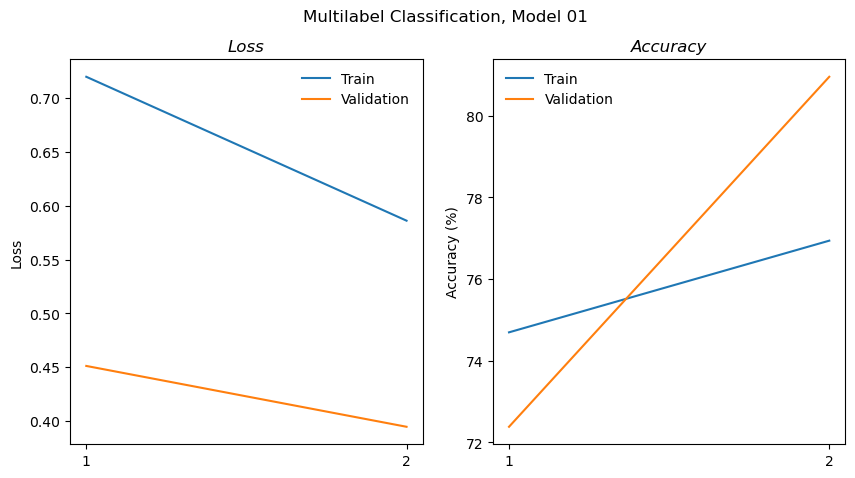

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

epochs = range(1, len(epoch_train_loss)+1)

ax[0].plot(epochs, epoch_train_loss, label='Train')
ax[0].plot(epochs, epoch_val_loss, label='Validation')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss', style='italic')

ax[1].plot(epochs, epoch_train_acc, label='Train')
ax[1].plot(epochs, epoch_val_acc, label='Validation')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy', style='italic')

for axes in ax:
    axes.legend(frameon=False)
    axes.set_xticks(epochs)

plt.suptitle('Multilabel Classification, Model 01')
plt.show()


# Test

0